In [107]:
import pandas as pd
import numpy as np
import cv2
from sklearn.utils import shuffle
from torch.autograd import Variable
from time import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt

In [8]:
import splitfolders
splitfolders.ratio('D:/MSDS/3rd Sem/ML/Assignment/CelebA/CelebA/dataset2', output="output2", seed=1337, ratio=(.8, .2)) 

Copying files: 1925 files [00:02, 895.59 files/s]


In [45]:
train_transform = transforms.Compose([
                transforms.Resize((64,64)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
                transforms.Normalize(
                                mean=[0.5, 0.5,0.5],
                                std=[0.5, 0.5,0.5])])
 
test_transform =transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(
                                mean=[0.5, 0.5,0.5],
                                std=[0.5, 0.5,0.5])])

In [46]:
def dataset_load(train_transform,test_transform,batch):
  # Loading Datasets using ImageFolder
  train_dataset = ImageFolder('D:/MSDS/3rd Sem/ML/Assignment/output2/train' , transform = train_transform) 
  print(len(train_dataset), 'Train Data')
  
  validation_dataset = ImageFolder('D:/MSDS/3rd Sem/ML/Assignment/output2/val' , transform = test_transform)
  print(len(validation_dataset) , "validation Data")
  
 

  # Train and Test dataloaders
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch)
  
  
  
  
  return train_loader,val_loader

In [83]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(        
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))
import numpy as np
import os
from PIL import Image
image_directory = r'D:/MSDS/3rd Sem/ML/Assignment/output2/train'
dataset = []
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(image_directory + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((178,218)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir= r'D:/MSDS/3rd Sem/ML/Assignment/output2/aug_train',
                          save_format='jpg'):    
    i += 1    
    if i > 50:        
        break

ModuleNotFoundError: No module named 'keras'

In [47]:
batch_size=64

train_loader,val_loader = dataset_load(train_transform,test_transform,batch_size)

1515 Train Data
410 validation Data


In [158]:
##########################
### MODEL
##########################


class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        # 28x28x1 => 28x28x8
        self.conv_1 = torch.nn.Conv2d(in_channels=3,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(28-1) - 28 + 3) / 2 = 1
        # 28x28x8 => 14x14x8
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(14-1) - 28 + 2) = 0                                       
        # 14x14x8 => 14x14x16
        self.conv_2 = torch.nn.Conv2d(in_channels=16,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(14-1) - 14 + 3) / 2 = 1                 
        # 14x14x16 => 7x7x16                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(7-1) - 14 + 2) = 0

        self.linear_1 = torch.nn.Linear(16*16*16, num_classes)

        
        
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)
        
        logits = self.linear_1(out.view(-1, 16*16*16))
        probas = F.log_softmax(logits, dim=1)
        
        return probas

In [159]:
model = ConvNet(100)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005)  

In [156]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

num_epochs=500       
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
    
    model = model.eval()
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs, 
          compute_accuracy(model, train_loader)))


Epoch: 001/500 | Batch 000/024 | Cost: 4.6057
Epoch: 001/500 training accuracy: 2.11%
Epoch: 002/500 | Batch 000/024 | Cost: 4.5824
Epoch: 002/500 training accuracy: 2.31%
Epoch: 003/500 | Batch 000/024 | Cost: 4.5834
Epoch: 003/500 training accuracy: 2.77%
Epoch: 004/500 | Batch 000/024 | Cost: 4.5734
Epoch: 004/500 training accuracy: 3.04%
Epoch: 005/500 | Batch 000/024 | Cost: 4.5378
Epoch: 005/500 training accuracy: 2.84%
Epoch: 006/500 | Batch 000/024 | Cost: 4.5292
Epoch: 006/500 training accuracy: 3.76%
Epoch: 007/500 | Batch 000/024 | Cost: 4.4486
Epoch: 007/500 training accuracy: 4.16%
Epoch: 008/500 | Batch 000/024 | Cost: 4.5084
Epoch: 008/500 training accuracy: 3.76%
Epoch: 009/500 | Batch 000/024 | Cost: 4.4636
Epoch: 009/500 training accuracy: 3.37%
Epoch: 010/500 | Batch 000/024 | Cost: 4.5306
Epoch: 010/500 training accuracy: 3.63%
Epoch: 011/500 | Batch 000/024 | Cost: 4.3949
Epoch: 011/500 training accuracy: 4.49%
Epoch: 012/500 | Batch 000/024 | Cost: 4.2839
Epoch: 0

In [157]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, val_loader)))

Test accuracy: 33.90%


In [160]:
def train(net, train_loader,learning_rate, n_epochs, loss_func, optimizer, device):
    train_loss = []
    train_acc=[]
    val_loss=[]
    val_acc=[]
    # training the model
    for epoch in range(n_epochs):
        tr_loss = 0
        tr_correct = 0
        v_loss=0
        v_correct=0
        # getting the training set
    
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)
            
            # clearing the Gradients of the model parameters
            optimizer.zero_grad()
            # prediction for training
            net_out = model(data)
            # computing the training and validation loss
            loss_train = loss_func(net_out, target)
            # computing the updated weights of all the model parameters
            loss_train.backward()
            optimizer.step()
            tr_loss += loss_train.item()
            pred = net_out.data.max(1)[1]  # get the index of the max log-probability
            tr_correct += pred.eq(target.data).sum()
            
        train_loss.append(tr_loss/len(train_loader.dataset))
        train_acc.append(tr_correct/len(train_loader.dataset))
    
        print("------------------------------------------------------------------------------------------------")
        print('Epoch: ', epoch)
        print('Training Loss:', tr_loss / len(train_loader.dataset)) 
        print("Training Accuracy:", 100. * tr_correct.item() / len(train_loader.dataset))
        print("------------------------------------------------------------------------------------------------") 
        
        
    return net, train_loss, train_acc

In [161]:
def save_network(path , model):
  torch.save(model.state_dict(), path)

In [162]:
def load_network(path, model):
  model.load_state_dict(torch.load(path))

In [163]:
def train_vitualization(train_loss,train_accuracy):

  plt.figure(figsize=(3,3))
  plt.title("Plot the resulting loss over time") 
  plt.plot(train_loss, label='Training Loss')
  plt.legend()
  plt.show()

  plt.figure(figsize=(3,3))
  plt.title("Plot the Resulting Acuracy over time")
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.legend()
  plt.show()

In [164]:
lr=0.005
n_epoch=100
# defining the model
# this statement tell our code if there gpu available on our machine or not.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet(num_classes=100)
model = model.to(device)
# defining the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
# defining the loss function
loss_func = nn.NLLLoss()
#loss_func = CrossEntropyLoss()
    
print(model)

model, train_loss, train_accuracy = train(model, train_loader,lr, n_epoch ,loss_func, optimizer, device)
save_network("Model.pt", model)


ConvNet(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=4096, out_features=100, bias=True)
)
------------------------------------------------------------------------------------------------
Epoch:  0
Training Loss: 0.07248493074977358
Training Accuracy: 1.7821782178217822
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Epoch:  1
Training Loss: 0.07084711219611341
Training Accuracy: 3.036303630363036
------------------------------------------------------------------------------------------------
-------------------

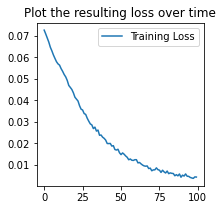

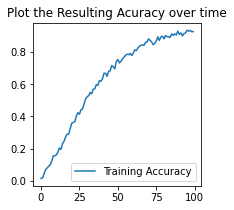

In [61]:
train_vitualization(train_loss, train_accuracy)

In [226]:
def test(model, device, test_loader):
    model.eval()
    
    test_acc=[]
    test_loss=[]
    t_loss =0
    correct=0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)
            net_out = model(data)
            loss = loss_func(net_out, target)
            
            t_loss += loss.item()
            pred = net_out.data.max(1)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data).sum()
            
        test_loss.append(t_loss/len(test_loader.dataset))
        test_acc.append(correct/len(test_loader.dataset))
        
        print("------------------------------------------------------------------------------------------------")
        print('Testing Loss:', t_loss/len(test_loader.dataset)) 
        print("Testing Accuracy:", 100. * correct.item() / len(test_loader.dataset))
        print("------------------------------------------------------------------------------------------------") 
        
        
    
    return  test_accuracy, test_loss
    
    

In [223]:
def conf(actuals, predictions):
  print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
  print('Accuracy score: %f' % accuracy_score(actuals, predictions))

  print('------------------------Confusion matrix----------------------------------')
  import seaborn as sns
  plt.figure(figsize=(10,9))
  ax = sns.heatmap(confusion_matrix(actuals, predictions), annot=True, vmax=30)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  plt.show()

In [228]:
load_network("Model.pt",model)
test_accuracy,test_loss = test(model, device, val_loader)

------------------------------------------------------------------------------------------------
Testing Loss: 0.08616129596058915
Testing Accuracy: 33.170731707317074
------------------------------------------------------------------------------------------------
